Trial 1 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 2 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 3 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 4 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 5 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 6 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 7 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 8 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 9 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 10 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 11 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 12 - Running baseline PSO...
Running LLM-enhanced PSO based on PSO result...
Trial 13 - Ru

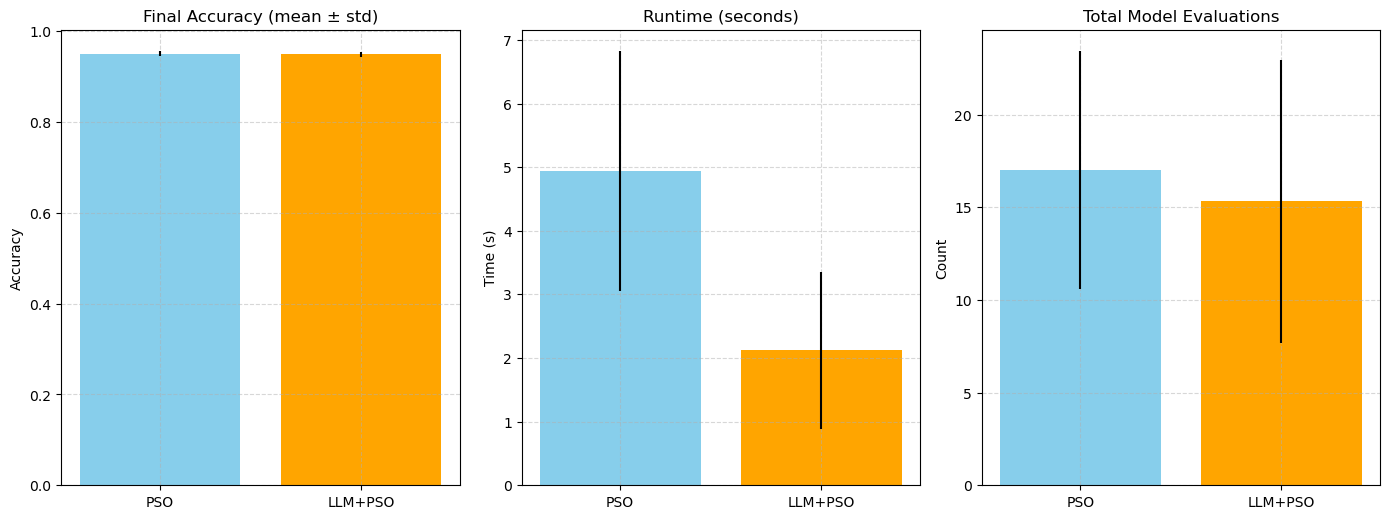

In [1]:
# --- Section 1: Imports ---
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import re
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from openai import OpenAI
from dotenv import load_dotenv

# --- Section 2: Load API Key ---
load_dotenv("OPENAI_API_KEY.env")
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# --- Section 3: LLM suggestion function ---
def suggest_new_particles(prev_best_C, prev_best_acc, iteration, num_particles):
    prompt = f"""
You are optimizing the regularization parameter C for logistic regression.
Current best C: {prev_best_C:.4f} with accuracy: {prev_best_acc:.4f} at iteration {iteration}.
Suggest {num_particles} new C values (between 0.0001 and 10.0) near the best C, while allowing some exploration.
If the previous accuracy was below 0.94, explore more aggressively; otherwise, refine tightly.
Return only a comma-separated list of numbers.
"""
    try:
        response = client.chat.completions.create(
            model="gpt-4",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7
        )
        content = response.choices[0].message.content
        values = [float(x.strip()) for x in content.split(",") if x.strip()]
        values = [min(max(v, 0.0001), 10.0) for v in values]
    except Exception as e:
        values = list(np.random.normal(loc=prev_best_C, scale=0.3, size=num_particles))
        values = [min(max(v, 0.0001), 10.0) for v in values]
    return [[v] for v in values]

# --- Section 4: PSO baseline optimization ---
def run_pso_baseline(X_train, X_test, y_train, y_test, max_iter=50):
    # Standard PSO with velocity, p_best, g_best
    history = []
    best_score = -1.0
    best_C = 1.0
    patience = 10
    epsilon = 0.0005
    no_improve_count = 0

    lb = [0.0001]
    ub = [10.0]
    swarm_size = 10
    
    particle_positions = np.random.uniform(lb[0], ub[0], size=(swarm_size, 1))
    particle_velocity = np.zeros_like(particle_positions)
    p_best_positions = np.copy(particle_positions)
    p_best_scores = np.full(swarm_size, -1.0)
    particle_velocity = np.zeros_like(particle_positions)
    p_best_positions = np.copy(particle_positions)
    p_best_scores = np.full(swarm_size, -1.0)
    particle_scores = np.full(swarm_size, np.inf)

    start_time = time.time()
    iter_num = 0

    w, c1, c2 = 0.5, 1.5, 1.5
    while iter_num < max_iter:
        for i in range(swarm_size):
            C = particle_positions[i][0]
            model = LogisticRegression(C=C, max_iter=1000)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            
            history.append((C, acc))

            if acc > p_best_scores[i]:
                p_best_scores[i] = acc
                p_best_positions[i] = particle_positions[i]

            if acc > p_best_scores[i]:
                p_best_scores[i] = acc
                p_best_positions[i] = particle_positions[i]

            if acc > best_score:
                best_score = acc
                best_C = C
                no_improve_count = 0
            
            else:
                no_improve_count += 1

            particle_scores[i] = -acc

        if no_improve_count >= patience:
            break

        # Get LLM suggested particles
        llm_particles = suggest_new_particles(best_C, best_score, iter_num, swarm_size)
        llm_attractor = np.mean(np.array(llm_particles), axis=0)

        # PSO update with LLM guidance
        w, c1, c2, c3 = 0.5, 1.5, 1.5, 1.2
        r1, r2, r3 = np.random.rand(swarm_size, 1), np.random.rand(swarm_size, 1), np.random.rand(swarm_size, 1)
        particle_velocity = (
            w * particle_velocity +
            c1 * r1 * (p_best_positions - particle_positions) +
            c2 * r2 * (best_C - particle_positions) +
            c3 * r3 * (llm_attractor - particle_positions)
        )
        particle_positions += particle_velocity
        particle_positions = np.clip(particle_positions, lb[0], ub[0])

        r1, r2 = np.random.rand(swarm_size, 1), np.random.rand(swarm_size, 1)
        particle_velocity = (
            w * particle_velocity +
            c1 * r1 * (p_best_positions - particle_positions) +
            c2 * r2 * (best_C - particle_positions)
        )
        particle_positions += particle_velocity
        particle_positions = np.clip(particle_positions, lb[0], ub[0])

        particle_positions = np.random.uniform(lb[0], ub[0], size=(swarm_size, 1))
        iter_num += 1

    end_time = time.time()
    return {
        "best_C": best_C,
        "final_acc": best_score,
        "time": end_time - start_time,
        "history": history,
        "eval_count": len(history),
        "total_models": swarm_size * iter_num
    }

# --- Section 5: LLM-enhanced PSO optimization ---
def run_llm_pso(X_train, X_test, y_train, y_test, best_C_seed, best_acc_seed, max_iter=50):
    # LLM-guided PSO: integrate LLM particles as attractors, not just replacements
    # Use PSO baseline best_acc_seed as target, not early stopping
    target_acc = best_acc_seed - 0.0001
    # Use independent best_score for LLM phase to allow fair early stopping
    history = []
    best_score = -1.0
    best_C = best_C_seed
    patience = 10
    epsilon = 0.0005
    no_improve_count = 0

    lb = [0.0001]
    ub = [10.0]
    swarm_size = 10
    particle_positions = np.random.uniform(lb[0], ub[0], size=(swarm_size, 1))
    particle_scores = np.full(swarm_size, np.inf)

    start_time = time.time()
    iter_num = 0

    while iter_num < max_iter:
        for i in range(swarm_size):
            C = particle_positions[i][0]
            model = LogisticRegression(C=C, max_iter=1000)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            history.append((C, acc))

            if acc > best_score + epsilon:
                best_score = acc
                best_C = C
                no_improve_count = 0
            else:
                no_improve_count += 1

            particle_scores[i] = -acc

        if no_improve_count >= patience:
            break

        worst_indices = np.argsort(particle_scores)[-2:]
        llm_particles = suggest_new_particles(best_C, best_score, iter_num, len(worst_indices))
        for idx, new_particle in zip(worst_indices, llm_particles):
            particle_positions[idx] = new_particle

        iter_num += 1

    end_time = time.time()
    return {
        "best_C": best_C,
        "final_acc": best_score,
        "time": end_time - start_time,
        "history": history,
        "eval_count": len(history),
        "total_models": swarm_size * iter_num
    }

# --- Section 6: Load and preprocess splice.data ---
with open("splice.data", "r") as file:
    lines = file.readlines()
data = [re.split(r"\s+", line.strip()) for line in lines]
df = pd.DataFrame(data, columns=["class", "id", "sequence"])
sequences = df["sequence"]
labels = df["class"]
char_sequences = [list(seq) for seq in sequences]
encoder = OneHotEncoder(sparse_output=False, dtype=int, handle_unknown='ignore')
X = encoder.fit_transform(char_sequences)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Section 7: Run multiple trials and average results ---
trials = 30
results = []
for trial in range(trials):
    print(f"Trial {trial+1} - Running baseline PSO...")
    result_pso = run_pso_baseline(X_train, X_test, y_train, y_test, max_iter=50)
    print("Running LLM-enhanced PSO based on PSO result...")
    result_llm = run_llm_pso(X_train, X_test, y_train, y_test, result_pso['best_C'], result_pso['final_acc'], max_iter=50)
    results.append((result_pso, result_llm))

# --- Section 8: Plot averaged comparison ---
plt.figure(figsize=(14, 10))

# Initialize lists
pso_accs, llm_accs, pso_times, llm_times, pso_models, llm_models = [], [], [], [], [], []

for pso, llm in results:
    pso_accs.append(pso['final_acc'])
    llm_accs.append(llm['final_acc'])
    pso_times.append(pso['time'])
    llm_times.append(llm['time'])
    pso_models.append(pso['total_models'])
    llm_models.append(llm['total_models'])

# Accuracy
plt.subplot(2, 3, 1)
plt.bar(['PSO', 'LLM+PSO'], [np.mean(pso_accs), np.mean(llm_accs)], yerr=[np.std(pso_accs), np.std(llm_accs)], color=['skyblue', 'orange'])
plt.title('Final Accuracy (mean ± std)')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.5)

# Runtime
plt.subplot(2, 3, 2)
plt.bar(['PSO', 'LLM+PSO'], [np.mean(pso_times), np.mean(llm_times)], yerr=[np.std(pso_times), np.std(llm_times)], color=['skyblue', 'orange'])
plt.title('Runtime (seconds)')
plt.ylabel('Time (s)')
plt.grid(True, linestyle='--', alpha=0.5)

# Model Evaluations
plt.subplot(2, 3, 3)
plt.bar(['PSO', 'LLM+PSO'], [np.mean(pso_models), np.mean(llm_models)], yerr=[np.std(pso_models), np.std(llm_models)], color=['skyblue', 'orange'])
plt.title('Total Model Evaluations')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
